In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1)
})

from matplotlib.ticker import ScalarFormatter
import datetime

In [2]:
flash_df = pd.read_csv(os.path.join("..","FlightData","Spring2025","ASCEND_flash_data_file_4_04_03_20_02_43.csv"))

custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
old_flash_df = pd.read_csv(os.path.join("..", "FlightData", "Fall2024", "ASCEND_DATA_2024_11_25_19_13_57.csv"), na_values=custom_na)

points_flash_df = sum(flash_df.count())
old_points_flash_df = sum(old_flash_df.count())

print("Spring 2025 Data Points:", points_flash_df)
print("Fall 2024 Data Points:", old_points_flash_df)


Spring 2025 Data Points: 623734
Fall 2024 Data Points: 229170


In [65]:
in_sample_counts = list(flash_df[flash_df["Minutes"] < 110].count())
print("Data Points In flight:",np.sum(in_sample_counts))


Data Points In flight: 237941


In [52]:
from tabulate import tabulate
from IPython.display import HTML, display

# datarate 
row_count = len(flash_df["Millis"])
millis_dur = flash_df["Millis"][row_count-1] - flash_df["Millis"][0]
sample_period = round((millis_dur/1000) / row_count, 4)

ignores = [] #["Receive time", "Header"]
sample_counts = list(flash_df.count())

print("Data Collection Stats:")
print("Recorded", len(flash_df["Millis"]), "rows", end=" ")
print("over", round(millis_dur / 1000 / 60, 2), "minutes")
print(len(flash_df.columns), "columns per row")
print(sum(sample_counts), "data points")
print()
print("Overall Sample Period:", sample_period, "seconds")
print("Overall Sample Frequency:", round(1/sample_period, 4), "Hz")
print()

table_list = [["Data Name", "Number of Samples", "Average Sample Frequency (Hz)", "Average Sample Period (s)", "Best Sample Period (s)", "Worst Sample Period (s)"]]

print("Analyzing Data", end="")
for i, col in enumerate(list(flash_df.columns)):
    if sample_counts[i] == 0 or (col in ignores): continue
    best_period = 10000
    worst_period = 0
    # find them
    last_found = -1
    print(".", end="")
    for r, val in enumerate(flash_df[col]):
        if str(val) != "nan":
            if last_found != -1:
                this_period = flash_df["Millis"][r] - last_found
#                 if(best_period != min(best_period, this_period)): print(original_flash_df["Millis"][r], best_period)
                best_period = min(best_period, this_period)
                worst_period = max(worst_period, this_period)
            last_found = flash_df["Millis"][r]
    best_period /= 1000
    worst_period /= 1000
            
    average_period = (millis_dur / 1000) / sample_counts[i] 
    average_frequency = 1 / average_period 
    
    entry = [col, sample_counts[i], round(average_frequency, 3), round(average_period, 3), best_period, worst_period]
    
    table_list.append(entry)

table_list.append(["By Device Average"] + [round(np.mean([table_list[i][j] for i in range(1, len(table_list))]), 3) for j in range(1, len(table_list[0]))])
table_list.append(["By Device Min"] + [round(np.min([table_list[i][j] for i in range(1, len(table_list))]), 3) for j in range(1, len(table_list[0]))])
table_list.append(["By Device Max"] + [round(np.max([table_list[i][j] for i in range(1, len(table_list))]), 3) for j in range(1, len(table_list[0]))])



print("Done.")


Data Collection Stats:
Recorded 18683 rows over 311.35 minutes
62 columns per row
673554 data points

Overall Sample Period: 0.9999 seconds
Overall Sample Frequency: 1.0001 Hz

Data Points In flight: 237941
Analyzing Data.....................................................Done.


In [4]:
table_html = tabulate(
    table_list,
    tablefmt="html",
    headers="firstrow"
)

display(HTML(table_html))

Data Name,Number of Samples,Average Sample Frequency (Hz),Average Sample Period (s),Best Sample Period (s),Worst Sample Period (s)
Millis,18683,1,1,0.719,1.647
PCF8523 Year,12454,0.667,1.5,1.386,2.312
PCF8523 Month,12454,0.667,1.5,1.386,2.312
PCF8523 Day,12454,0.667,1.5,1.386,2.312
PCF8523 Hour,12454,0.667,1.5,1.386,2.312
PCF8523 Minute,12454,0.667,1.5,1.386,2.312
PCF8523 Second,12454,0.667,1.5,1.386,2.312
INA260 Current (mA),12454,0.667,1.5,1.386,2.312
INA260 Voltage (mV),12454,0.667,1.5,1.386,2.312
INA260 Power (mW),12454,0.667,1.5,1.386,2.312


# Layers of the Atmosphere

In [5]:
# grapher 
def timePlot(df, time_col, unit, var1, var2, fills):
    fig, ax = plt.subplots(dpi=200)
    fig.set_figwidth(9)
    fig.set_figheight(5)
    
    if(var2 != None):
        plot_title = f"{var1[1]} and {var2[1]} vs Time"
    else:
        plot_title = f"{var1[1]} vs Time"
    
    plt.title(plot_title, fontsize="large", loc="left", fontweight="bold", family="monospace")
    
    ax.set_xlabel(f"Time ({unit})", fontsize="large", fontweight="bold")
    ax.set_ylabel(f"{var1[1]} ({var1[2]})", fontsize="large", fontweight="bold")
    line1 = plt.plot(time_col, var1[0], data=df, marker='o', markersize=2, color=var1[3], linewidth=2)    
    
    if(var2 != None):
        ax2 = ax.twinx()
        ax2.set_ylabel(f"{var2[1]} ({var2[2]})", fontsize="large", fontweight="bold")
        line2 = plt.plot(time_col, var2[0], data=df, marker='o', markersize=2, color=var2[3], linewidth=2)

    ax.set_ylim([None, ax.get_ylim()[1] * 1.25]);
    
    if(var2 != None):
        legendObj = line1 + line2
        legendLabels = [line1[0].get_label(), line2[0].get_label()]
    else:
        legendObj = line1
        legendLabels = [line1[0].get_label()]

    top = ax.get_ylim()[1]
    bottom = ax.get_ylim()[0]
    for fill in fills: 
        if str(fill[1]) == "nan": continue
        xstart = fill[1]
        if str(fill[2]) != "nan": xstop = fill[2]
        else: xstop = ax.get_xlim()[1]
        fill1 = ax.fill([xstart, xstop, xstop, xstart],[top, top, bottom, bottom], alpha=fill[6], label=fill[0], color=fill[5])
        legendObj += fill1
        legendLabels.append(fill1[0].get_label())
    ax.legend(legendObj, legendLabels)
    
    plt.show()


In [6]:
# General altitude 

flash_df["Minutes"] = flash_df["Millis"] / 1000 / 60 
flash_df["GPS Alt km"] = flash_df["MTK3339 Altitude"] / 1000 / 1000

temp_alt = [[], [], []]
for i, row in flash_df.iterrows():
    if row["Minutes"] > 110: break 
    if np.isnan(row["MTK3339 Altitude"]) == False:
        temp_alt[0].append(row["TMP117_O Temp_O (C)"])
        temp_alt[1].append(row["MTK3339 Altitude"] / 1000 / 1000)
        temp_alt[2].append(i)
        
print(len(temp_alt[0]))


2200


In [7]:

# tropopause
# characteristics -51C (I think)
# decrease stalls 
tropopause_begin = 0
tropopause_end = 0
# temp decase is 2C / km or less
offset = 50
increase_lookahead = 10

print(np.max(temp_alt[1]))

for i in range(len(temp_alt[0])-increase_lookahead):
    if temp_alt[1][i] < 5: 
        continue
    C_change = (temp_alt[0][i+offset] - temp_alt[0][i])
    alt_change = (temp_alt[1][i+offset] - temp_alt[1][i])
    if abs(alt_change) <= 1: continue
    
    C_by_km = C_change / alt_change
#     print(C_by_km)
    if -2 < C_by_km < 0 and tropopause_begin == 0: 
        print(C_by_km)
        tropopause_begin = int(temp_alt[2][i] + offset)
    
    if C_by_km > 2 and tropopause_begin != 0 and temp_alt[0][i+offset] < temp_alt[0][i+offset+increase_lookahead]: 
        print(C_by_km)
        tropopause_end = int(temp_alt[2][i] + offset)
        break 
        
print(tropopause_begin, tropopause_end)
while np.isnan(flash_df["MTK3339 Altitude"][tropopause_begin]):
    tropopause_begin += 1
    
while np.isnan(flash_df["MTK3339 Altitude"][tropopause_end]):
    tropopause_end += 1

print(flash_df["MTK3339 Altitude"][tropopause_begin] * 0.00328084)
print(flash_df["MTK3339 Altitude"][tropopause_end] * 0.00328084)



28.911436000000002
-1.8864338382209762
2.0232772529927905
1684 2392
36214.44013524
56101.58972176


In [8]:
# stratosphere 
# temp climes again 


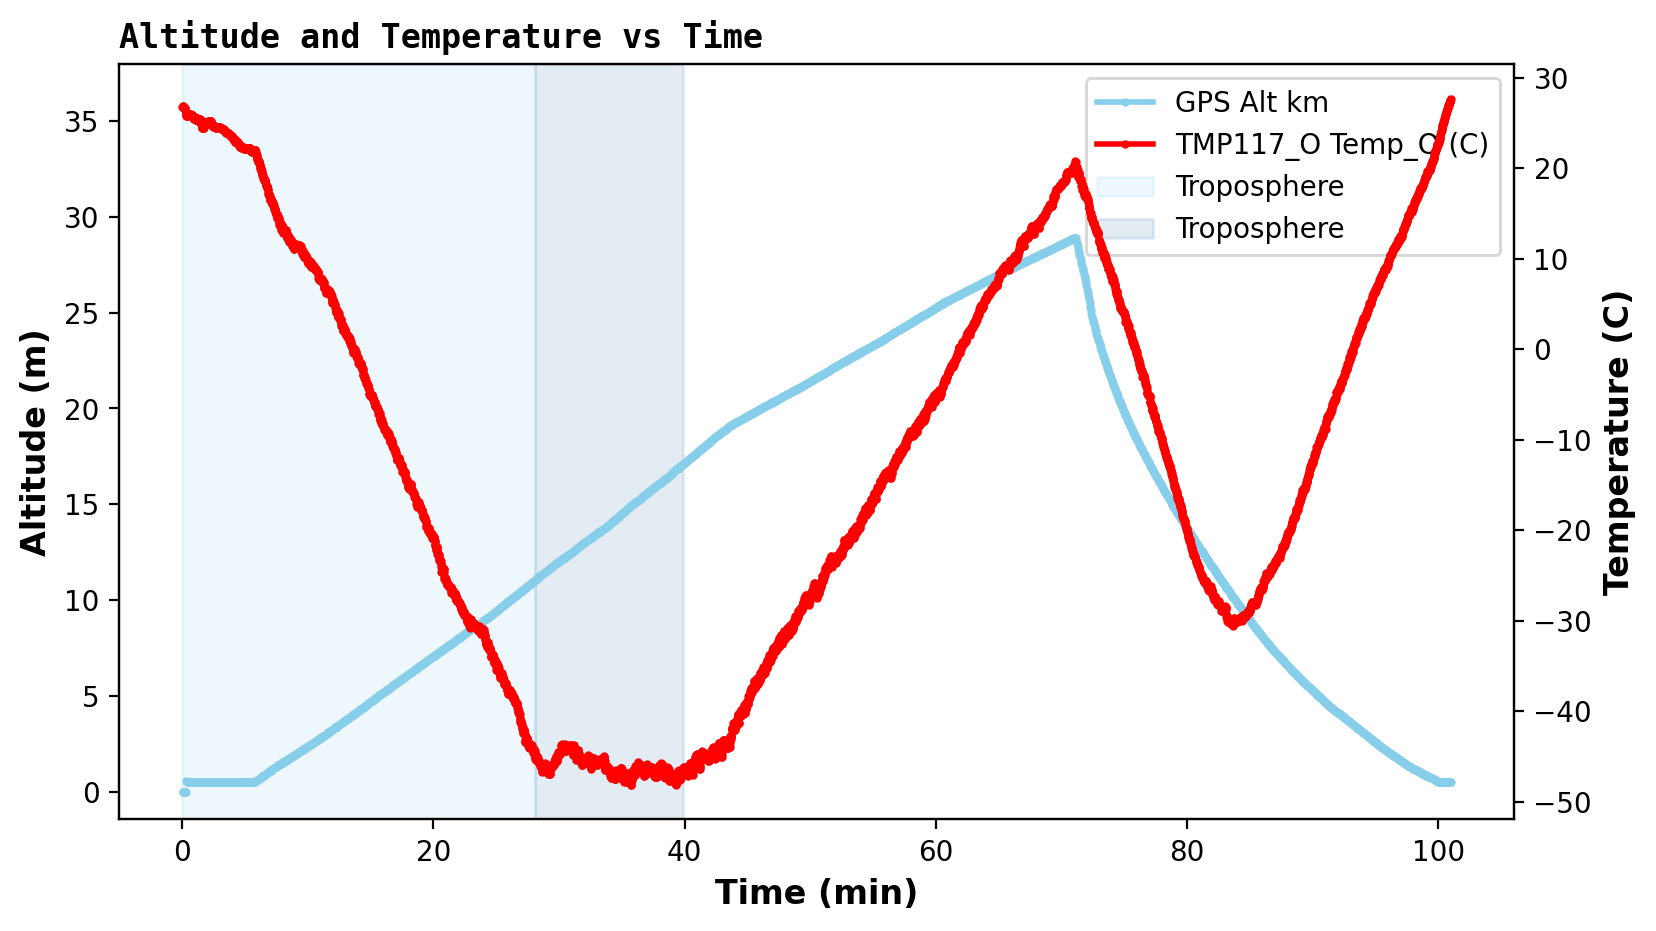

In [66]:
# graph

shaders = []

shaders.append((
    "Troposphere", 
    flash_df["Minutes"][0],
    flash_df["Minutes"][tropopause_begin],
    flash_df["BMP390 Pressure (Pa)"][0],
    flash_df["BMP390 Pressure (Pa)"][tropopause_begin],
    "skyblue", 0.15
))

shaders.append((
    "Troposphere", 
    flash_df["Minutes"][tropopause_begin],
    flash_df["Minutes"][tropopause_end],
    flash_df["BMP390 Pressure (Pa)"][tropopause_begin],
    flash_df["BMP390 Pressure (Pa)"][tropopause_end],
    "steelblue", 0.15
))

timePlot(flash_df[flash_df["Minutes"] < 101], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("TMP117_O Temp_O (C)", "Temperature", "C", "red"), shaders)


shaders.append((
    "Stratosphere", 
    flash_df["Minutes"][tropopause_end],
    flash_df["Minutes"][ozone_begin],
    flash_df["BMP390 Pressure (Pa)"][tropopause_end],
    flash_df["BMP390 Pressure (Pa)"][ozone_begin],
    "dodgerblue", 0.15
))


1365
0 0


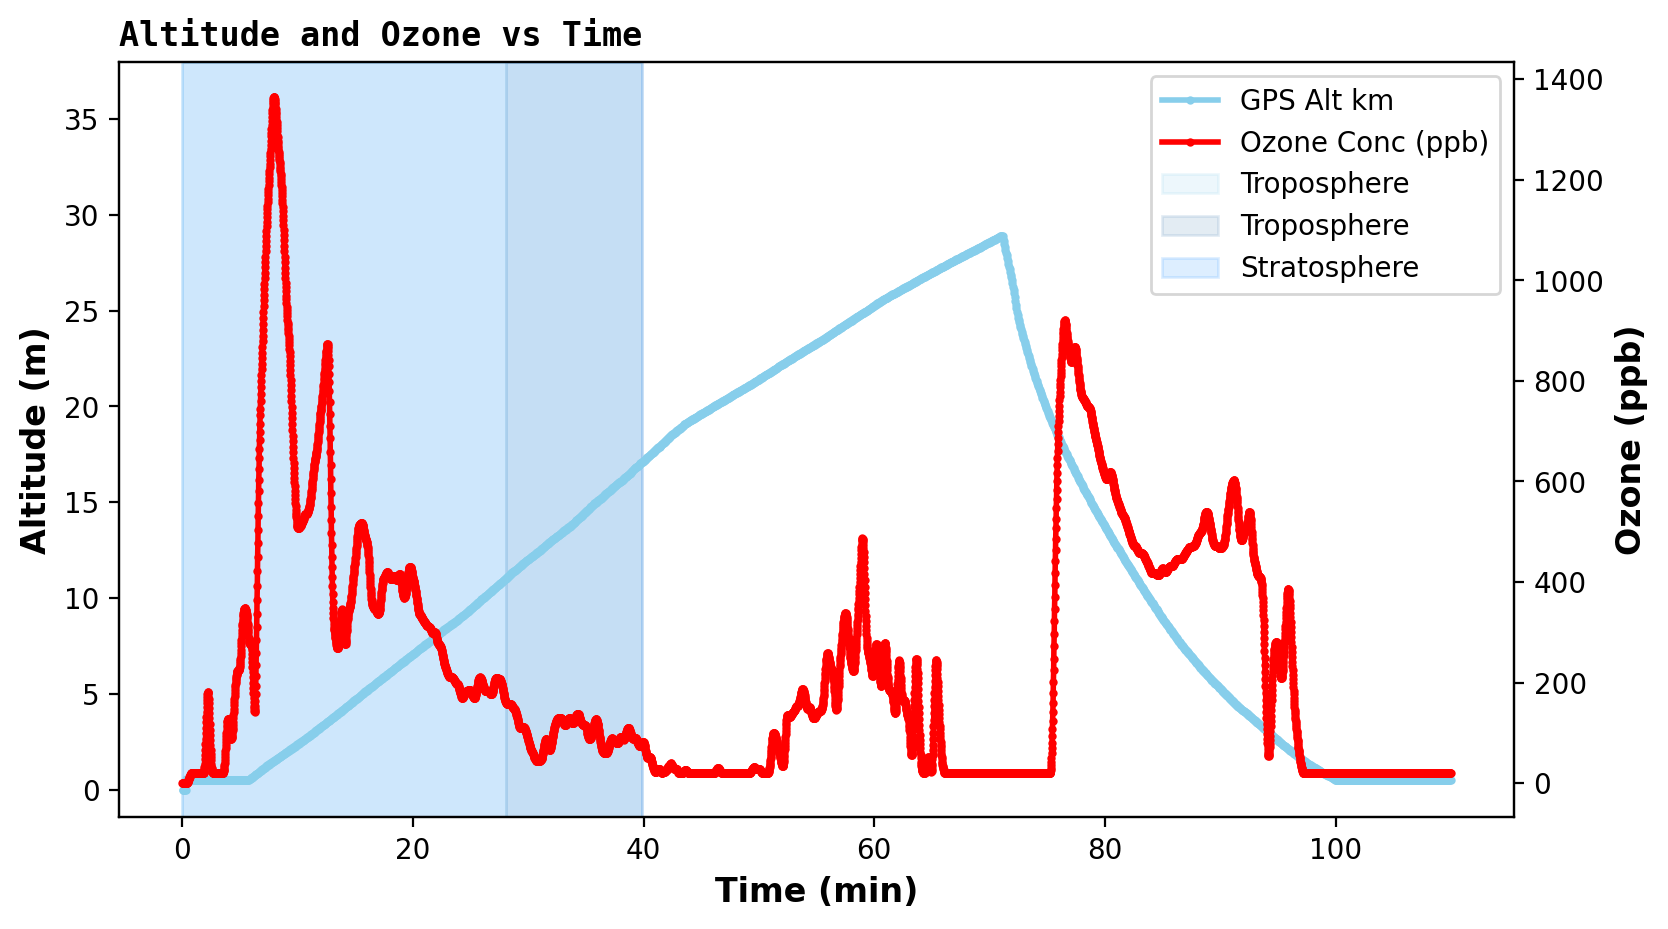

In [11]:
# ozone layer bottom 
# in stratosphere 
# starts at 2 ppm ozone concentration 
ozone_begin = 0
ozone_end = 0

print(np.max(flash_df["Ozone Conc (ppb)"]))

for i, row in flash_df.iloc[tropopause_end:].iterrows():
    if np.isnan(row["Ozone Conc (ppb)"]): continue

    if ozone_begin == 0 and row["Ozone Conc (ppb)"] > 2000: 
        ozone_begin = i
    
print(ozone_begin, ozone_end)


timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("Ozone Conc (ppb)", "Ozone", "ppb", "red"), shaders)


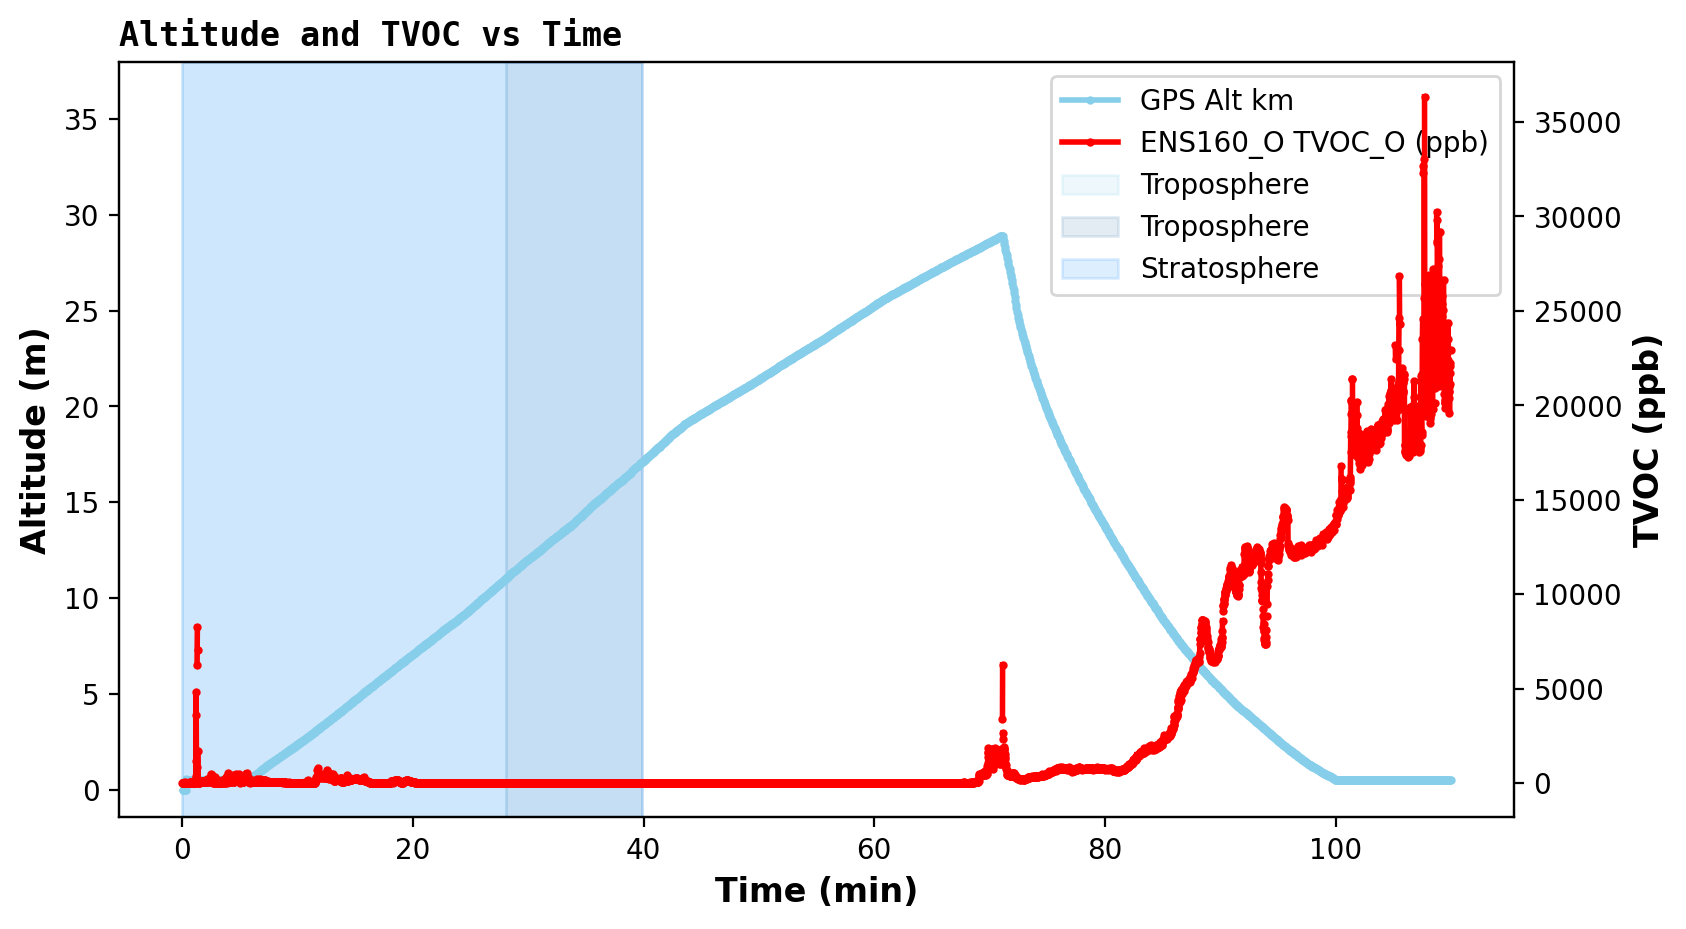

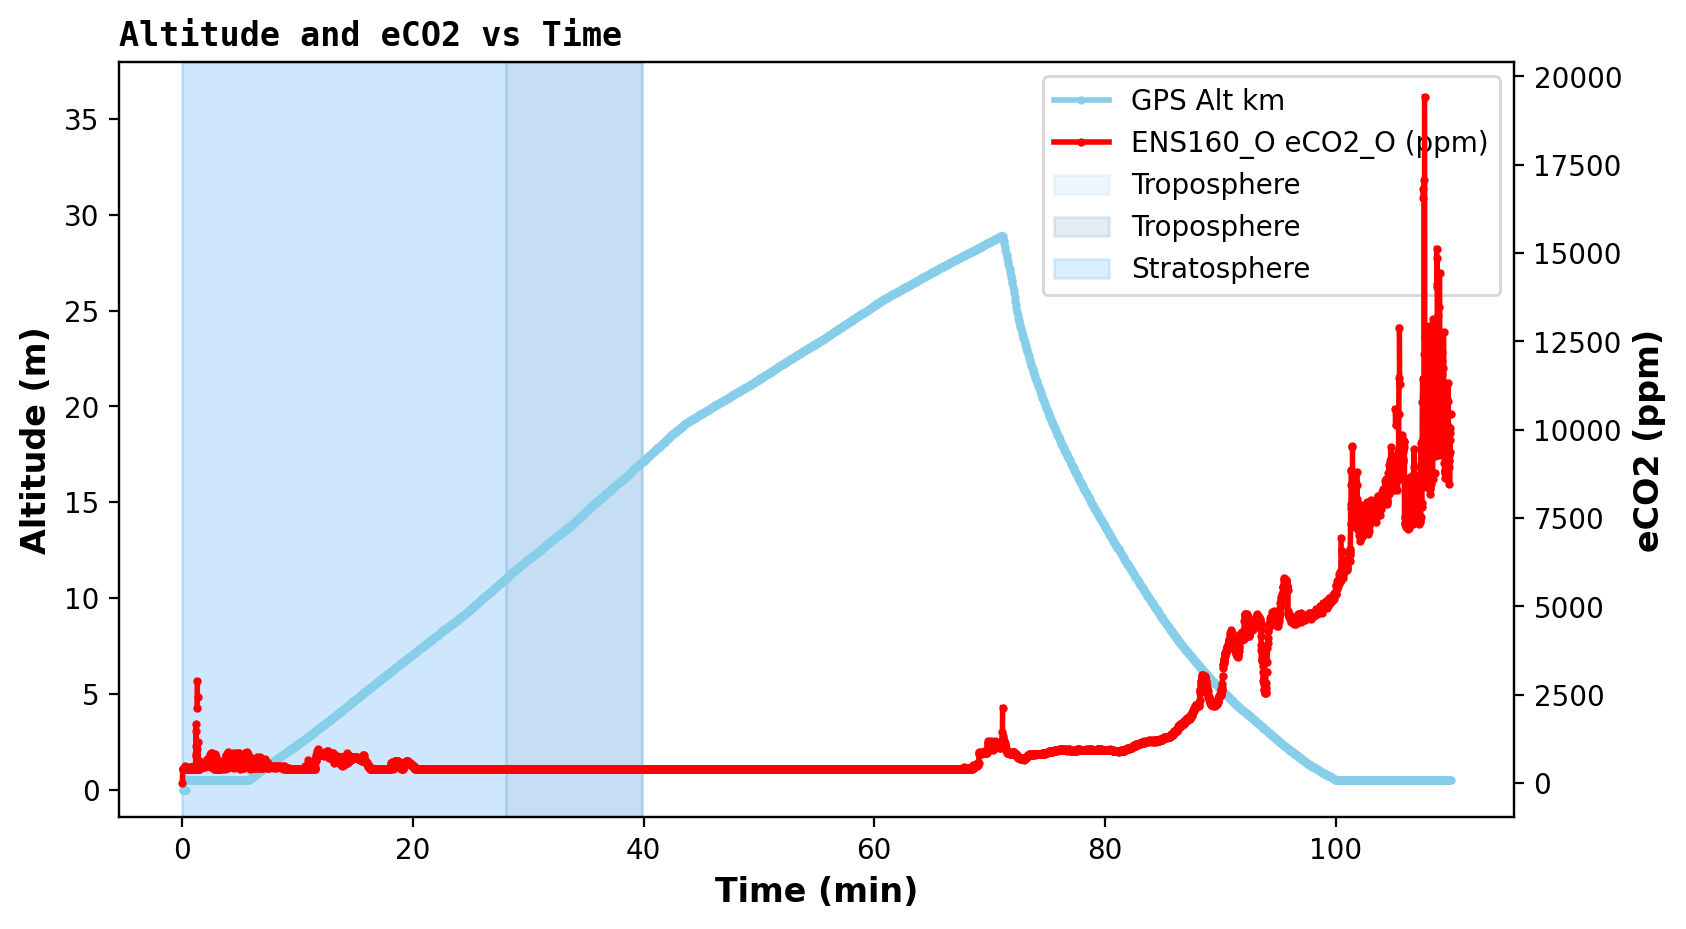

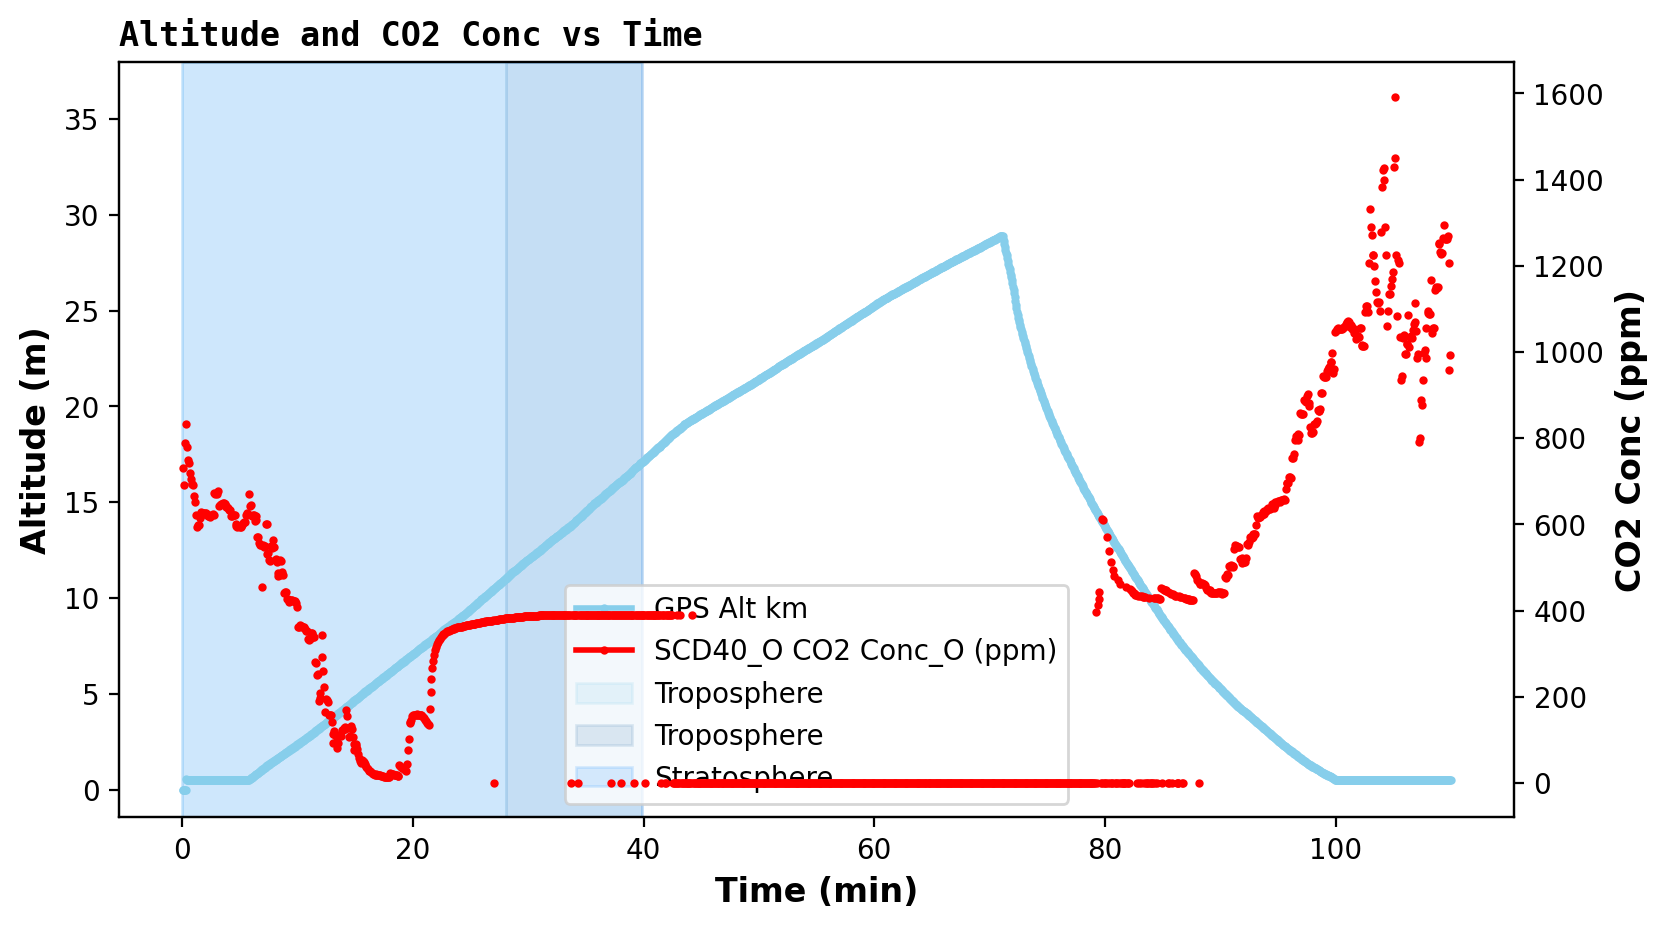

In [14]:

timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("ENS160_O TVOC_O (ppb)", "TVOC", "ppb", "red"), shaders)
timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("ENS160_O eCO2_O (ppm)", "eCO2", "ppm", "red"), shaders)
timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("SCD40_O CO2 Conc_O (ppm)", "CO2 Conc", "ppm", "red"), shaders)


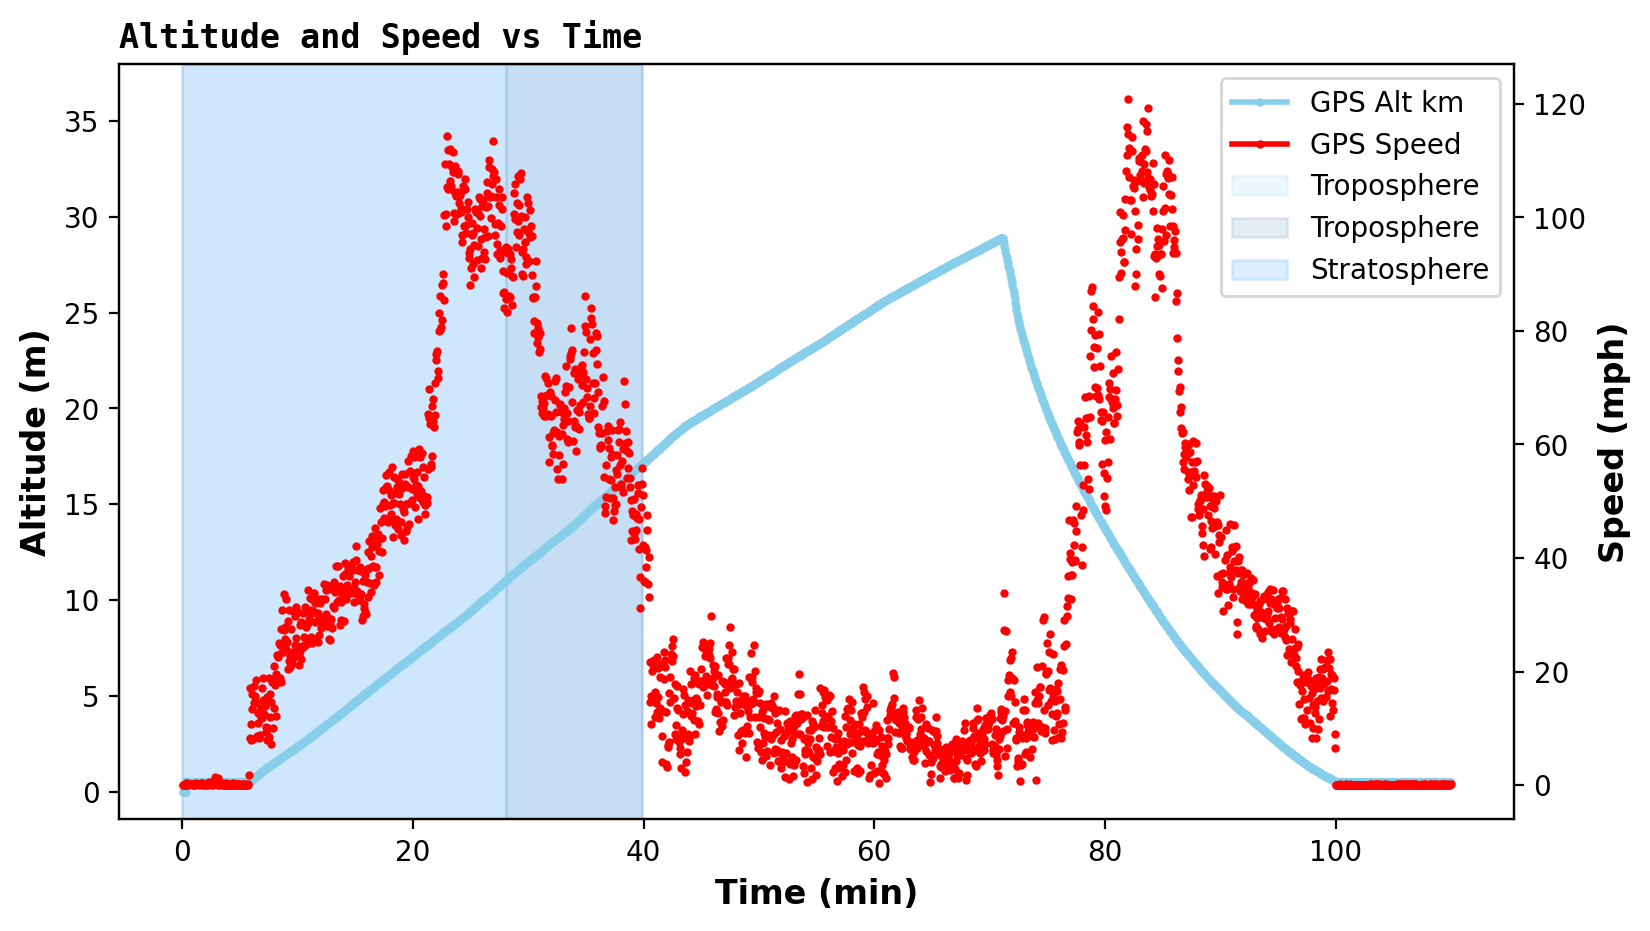

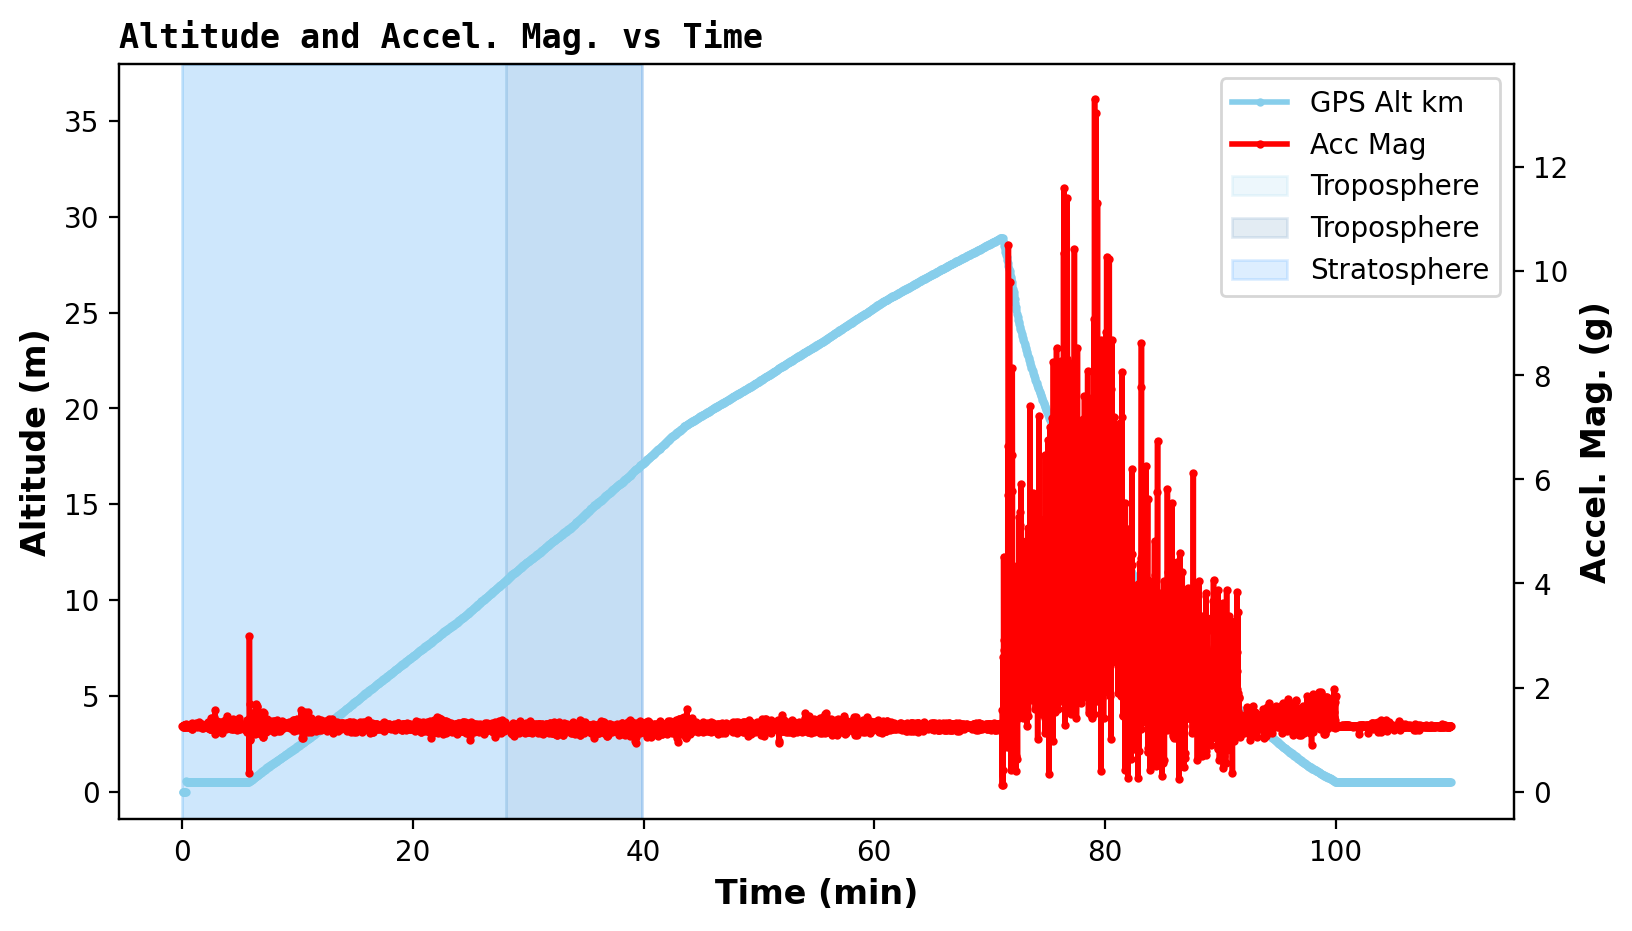

In [38]:
# ICM20948 AccX (g)    MTK3339 Speed
flash_df["GPS Speed"] = flash_df["MTK3339 Speed"] / 1000 * 2.236936
flash_df["Acc Mag"] = np.sqrt(flash_df["ICM20948 AccX (g)"]**2 + flash_df["ICM20948 AccY (g)"]**2 + flash_df["ICM20948 AccZ (g)"]**2) / 8

timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("GPS Speed", "Speed", "mph", "red"), shaders)
timePlot(flash_df[flash_df["Minutes"] < 110], "Minutes", "min", ("GPS Alt km", "Altitude", "m", "skyblue"), ("Acc Mag", "Accel. Mag.", "g", "red"), shaders)



In [51]:
# types 
ran = 5
acc_max = np.mean(sorted((flash_df["Acc Mag"]))[-ran:])
print(np.max(flash_df["Acc Mag"]), "g")
print(f"avg ({ran}):", acc_max, "g")

speeds = [i for i in flash_df["GPS Speed"] if np.isnan(i) == False]
speed_max = np.mean(sorted(speeds)[-ran:])
print(np.max(flash_df["GPS Speed"]), "mph")
print(f"avg ({ran}):", speed_max, "mph")


13.314143796404682 g
avg (5): 12.134981140442582 g
120.890732248 mph
avg (5): 117.91515998079998 mph


### 